In [459]:
#Importing Libraries
import math
import scipy
import statistics
import glob
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from pyedflib import highlevel
from scipy.signal import spectrogram, welch
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

### To start off, a bit of background information about EEG needs to be given. An EEG is a test that captures the brain's electrical activity. These test typical are done using a cap comprised of 21 electrodes in the positioning shown in the figure below. <img src='/Users/lperry21/Documents/BME 4050/1200px-21_electrodes_of_International_10-20_system_for_EEG.png' alt="EEG Electrode Positioning" style="float: left; margin-right: 10px;" />

### The most important features within an EEG signal are the brain waves which are broken up into 4 primary bands: **Delta (0.4 - 4 Hz), Theta (4-8 Hz), Alpha (8-13 Hz), and Beta (13 - 50 Hz)**. 

#### These brain wave features will be the main focus of the data analysis. Most Time-domain features carry virtually no valuable information due to heavy influence from outside factors such as skin conductivity, hair type and length, and equipment/electrode connection. All these factors can alter the magnitude of the signal which makes the power of the signal vary for reasons other than the actual brain activity. For this reason, the bands will also be based as a percent of total power of the frequency response. There are several ways the features can be extracted but one way that will be looked at is simply taking the frequency response of the 60 s signal and giving the entire frequency response to the model as the data. The typical EEG set is comprised of 21 different electrodes but the A1-A2 is a normally combined so the EEG has 20 signals. The frequency response will be 256 samples long each for all 20 electrodes which totals to 5020 features. This many features will probably result in very poor performance as it is likely too much information to find a meaningful trend. Therefore, to cut back on the amount of information, I will sum all frequencies within the band ranges to get the total band power. This can be done in different ways depending on what bands you use. There is evidence that suggest there are ways to further classify the brain waves into more bands. Recent studies suggest that beta can be broken up into **Beta I (13-30 Hz)** and **Beta II (30-50 Hz)**. There is also evidence that the higher frequencies may have some clinical relevance so the band **Gammma (50+ Hz)** has also been recognized. All these feature groups will be explored in the training.

### In the first run, we will break up the bands into the main 4 bands for each electrode resulting in 80 features.

In [379]:
#Basic band function
def band_power(data, Fs, label):
    freq, Sxx= welch(data, Fs, nperseg=Fs*2, noverlap=Fs/2 , scaling='spectrum')
    Sxx = Sxx.T

    delta_band = 0
    theta_band = 0
    alpha_band = 0
    beta_band = 0
    # print(f'Expected length of time = {(T2-T1)/100}')
    # print(f'len(time) = {len(time)}')
    for f in freq:
        if f<=4:
            delta_band+=Sxx[freq==f]
        elif f<8:
            theta_band+=Sxx[freq==f]
        elif f<=13:
            alpha_band+=Sxx[freq==f]
        elif f<=50:
            beta_band+=Sxx[freq==f]
    total_power = delta_band + theta_band+ alpha_band + beta_band
    delta_band/=total_power
    theta_band/=total_power
    alpha_band/=total_power
    beta_band/=total_power

    headers = [str(label)+' delta',str(label)+' theta', str(label)+' alpha', str(label)+' beta']
    delta_band = pd.DataFrame(delta_band, columns=[headers[0]])
    theta_band = pd.DataFrame(theta_band, columns=[headers[1]])
    alpha_band = pd.DataFrame(alpha_band, columns=[headers[2]])
    beta_band = pd.DataFrame(beta_band, columns=[headers[3]])
    bands = pd.concat([delta_band, theta_band, alpha_band, beta_band], axis=1)
    return bands


In [380]:
#This is a small test to see the columns produced by the process
signals, signal_headers, header = highlevel.read_edf('/Users/lperry21/Documents/BME 4050/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_2.edf')
print('Signal Header = ')
for index in range(len(signal_headers)):
    if signal_headers[index]['label'] == 'ECG ECG':
        pass
    elif index == 0:
        print(signal_headers[index]['label'])
        subject1_data = band_power(signals[index],Fs=500,label=signal_headers[index]['label'])
    else:
        print(signal_headers[index]['label'])
        new_signal = band_power(signals[index],Fs=500,label=signal_headers[index]['label'])
        subject1_data = pd.concat([subject1_data,new_signal], axis=1)
print(f'subject1_data.columns = \n {subject1_data.columns}')
print(f'len(subject1_data.columns) = {len(subject1_data.columns)}')

Signal Header = 
EEG Fp1
EEG Fp2
EEG F3
EEG F4
EEG F7
EEG F8
EEG T3
EEG T4
EEG C3
EEG C4
EEG T5
EEG T6
EEG P3
EEG P4
EEG O1
EEG O2
EEG Fz
EEG Cz
EEG Pz
EEG A2-A1
subject1_data.columns = 
 Index(['EEG Fp1 delta', 'EEG Fp1 theta', 'EEG Fp1 alpha', 'EEG Fp1 beta',
       'EEG Fp2 delta', 'EEG Fp2 theta', 'EEG Fp2 alpha', 'EEG Fp2 beta',
       'EEG F3 delta', 'EEG F3 theta', 'EEG F3 alpha', 'EEG F3 beta',
       'EEG F4 delta', 'EEG F4 theta', 'EEG F4 alpha', 'EEG F4 beta',
       'EEG F7 delta', 'EEG F7 theta', 'EEG F7 alpha', 'EEG F7 beta',
       'EEG F8 delta', 'EEG F8 theta', 'EEG F8 alpha', 'EEG F8 beta',
       'EEG T3 delta', 'EEG T3 theta', 'EEG T3 alpha', 'EEG T3 beta',
       'EEG T4 delta', 'EEG T4 theta', 'EEG T4 alpha', 'EEG T4 beta',
       'EEG C3 delta', 'EEG C3 theta', 'EEG C3 alpha', 'EEG C3 beta',
       'EEG C4 delta', 'EEG C4 theta', 'EEG C4 alpha', 'EEG C4 beta',
       'EEG T5 delta', 'EEG T5 theta', 'EEG T5 alpha', 'EEG T5 beta',
       'EEG T6 delta', 'EEG T6 the

In [381]:
#Collecting data, Features used in this set are the 4 freq bands for each electrode
set_made=False
data_files = glob.glob("/Users/lperry21/Documents/BME 4050/eeg-during-mental-arithmetic-tasks-1.0.0/*.edf")
for index, file in enumerate(data_files):
    signals, signal_headers, header = highlevel.read_edf(file)
    for index in range(len(signal_headers)):
        if signal_headers[index]['label'] == 'ECG ECG':
            pass
        elif index == 0:
            subject1_data = band_power(signals[index],Fs=500,label=signal_headers[index]['label'])
        else:
            new_signal = band_power(signals[index],Fs=500,label=signal_headers[index]['label'])
            subject1_data = pd.concat([subject1_data,new_signal], axis=1)
    y = int(file[-5])-1 #file[-5] is the class for background (1) or mental math (2)
    ID = pd.DataFrame([header['patientname']], columns=['Subject ID'])
    y = pd.DataFrame([y], columns=['class'])
    subject1_data = pd.concat([subject1_data,y,ID], axis=1)
    if set_made == False:
        dataset = subject1_data
        set_made = True
    else:
        dataset = pd.concat([dataset,subject1_data], axis=0)
dataset = dataset.set_index('Subject ID')
dataset

,EEG Fp1 delta,EEG Fp1 theta,EEG Fp1 alpha,EEG Fp1 beta,EEG Fp2 delta,EEG Fp2 theta,EEG Fp2 alpha,EEG Fp2 beta,EEG F3 delta,EEG F3 theta,...,EEG Cz beta,EEG Pz delta,EEG Pz theta,EEG Pz alpha,EEG Pz beta,EEG A2-A1 delta,EEG A2-A1 theta,EEG A2-A1 alpha,EEG A2-A1 beta,class
Subject ID,,,,,,,,,,,,,,,,,,,,,
Subject20,0.443907,0.136498,0.212809,0.206786,0.556585,0.098501,0.163061,0.181852,0.308834,0.123659,...,0.149357,0.404447,0.089714,0.347132,0.158708,0.492481,0.103544,0.209810,0.194165,0
Subject6,0.893370,0.036415,0.035546,0.034669,0.714693,0.088438,0.090141,0.106727,0.622431,0.092001,...,0.116303,0.530133,0.097602,0.202356,0.169910,0.540552,0.086152,0.158812,0.214484,1
Subject4,0.652261,0.129190,0.111498,0.107051,0.786816,0.071004,0.071987,0.070192,0.640374,0.119047,...,0.121192,0.489359,0.092007,0.313464,0.105171,0.714355,0.095749,0.112373,0.077522,0
Subject22,0.800723,0.060110,0.090262,0.048905,0.742658,0.070750,0.124239,0.062354,0.510656,0.144968,...,0.119229,0.473315,0.105368,0.282135,0.139182,0.569945,0.092457,0.166921,0.170677,1
Subject6,0.677740,0.125303,0.112741,0.084216,0.688773,0.126570,0.100516,0.084141,0.727456,0.104782,...,0.098861,0.506999,0.096999,0.291773,0.104229,0.610764,0.089141,0.176041,0.124054,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Subject11,0.772659,0.056280,0.052196,0.118864,0.669259,0.068607,0.064863,0.197272,0.608424,0.116028,...,0.109483,0.755670,0.086115,0.072435,0.085781,0.397393,0.116572,0.169964,0.316072,1
Subject13,0.879324,0.062583,0.029274,0.028818,0.743448,0.137700,0.062041,0.056811,0.743557,0.136126,...,0.062829,0.645146,0.169947,0.108345,0.076562,0.471636,0.229899,0.151035,0.147430,1
Subject35,0.661475,0.112377,0.111267,0.114880,0.588275,0.126262,0.130665,0.154798,0.662659,0.120627,...,0.077060,0.634924,0.091016,0.150696,0.123364,0.671835,0.091754,0.097112,0.139299,0


### The data so far looks good but the small sample number may play a role with model training. Lets run a few basic models to test general performance.

#### First we need to split the data into train and test sets.

In [407]:
#Train test splitting
Data = dataset.copy()
Y = Data['class']
X = Data.drop(columns='class')
# print('X')
# print(X)
# print('Y')
# print(Y)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.35, stratify=Y, random_state=21)
#Lets see the data break down
print('Training set dimensions')
print(trainX.shape)
print(trainY.shape)
#Class distribution
print('Class 0 (Background EEG)')
print(len(trainY[trainY==0]))
print('Class 1 (Mental Math EEG)')
print(len(trainY[trainY==1]))
# print(trainX)

print('\nTest set dimensions')
print(testX.shape)
print(testY.shape)
#Class distribution
print('Class 0 (Background EEG)')
print(len(testY[testY==0]))
print('Class 1 (Mental Math EEG)')
print(len(testY[testY==1]))

Training set dimensions
(46, 80)
(46,)
Class 0 (Background EEG)
23
Class 1 (Mental Math EEG)
23

Test set dimensions
(26, 80)
(26,)
Class 0 (Background EEG)
13
Class 1 (Mental Math EEG)
13


### For the models, I will be using a voting classifier that will take several different classifier and have them vote on the classification. The first classifier will be a K-Nearest Neighbors model with the default value of 5 for n_neighbors. The second model will be a AdaBoosted Linear Support Vector Classifier. The final model will be a Random Forrest Classifier.

In [408]:
#Repeatable test method
def test_models(models):
    for model, label in models:
        print(f'########## {label} ##########')
        # Fit model (Logistic Reg.) to the Training data
        model.fit(trainX, trainY)
            
        # Predict the classes (y) from test features (X)
        predictedY = model.predict(testX)


        # print quality metrics
        print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

        print('\nTesting Confusion Matrix:\n')
        disp = ConfusionMatrixDisplay.from_predictions(testY, predictedY, normalize='pred')
        plt.show()

########## Classifier: K-Nearest neighbors ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.62      1.00      0.76        13
           1       1.00      0.38      0.56        13

    accuracy                           0.69        26
   macro avg       0.81      0.69      0.66        26
weighted avg       0.81      0.69      0.66        26


Testing Confusion Matrix:



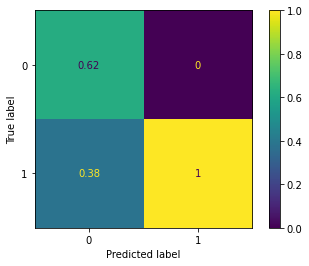

########## Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       0.75      0.69      0.72        13

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26


Testing Confusion Matrix:



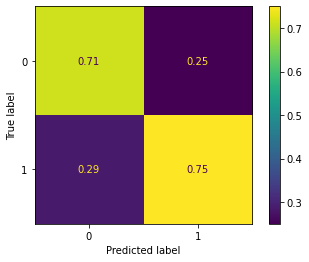

########## Classifier: Random Forest Classifier ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.75      0.92      0.83        13

    accuracy                           0.81        26
   macro avg       0.82      0.81      0.81        26
weighted avg       0.83      0.81      0.81        26


Testing Confusion Matrix:



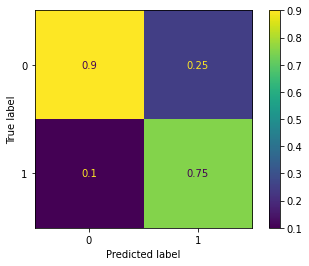

########## Classifier: Ensemble Voting Classifier (Hard) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.85      0.85      0.85        13

    accuracy                           0.85        26
   macro avg       0.85      0.85      0.85        26
weighted avg       0.85      0.85      0.85        26


Testing Confusion Matrix:



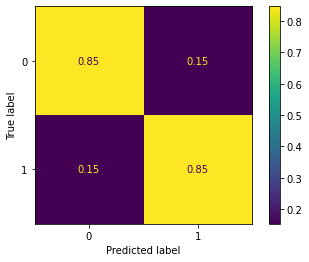

In [413]:
model_KN = KNeighborsClassifier()              # Classifier: Nearest neighbors
model_SV = svm.LinearSVC()                     # Classifier: Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_SV_boost = AdaBoostClassifier(model_SV, algorithm='SAMME') # Classifier: Boosted Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_RF = RandomForestClassifier()            # Classifier: Random Forest Classifier
model_VC = VotingClassifier(estimators=[('KN', model_KN), ('LSVC', model_SV), ('RF', model_RF), ('LSVC_B', model_SV_boost)], voting='hard')
models = [[model_KN, 'Classifier: K-Nearest neighbors'], [model_SV_boost, 'Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC)'],
        [model_RF, 'Classifier: Random Forest Classifier'], [model_VC, 'Classifier: Ensemble Voting Classifier (Hard)']]
test_models(models)

### These results are pretty good given the low sample size. The final voting classifier model was able to get a 85% accuracy. Let try these models with different features. We will expand the bands to the 6 different bands: **Delta, Theta, Alpha, Beta I, Beta II, and Gamma**

In [424]:
#New band collect function
def new_band_power(data, Fs, label):
    freq, Sxx= welch(data, Fs, scaling='spectrum')
    Sxx = Sxx.T

    delta_band = 0
    theta_band = 0
    alpha_band = 0
    beta1_band = 0
    beta2_band = 0
    gamma_band = 0
    # print(f'Expected length of time = {(T2-T1)/100}')
    # print(f'len(time) = {len(time)}')
    for f in freq:
        if f<=4:
            delta_band+=Sxx[freq==f]
        elif f<8:
            theta_band+=Sxx[freq==f]
        elif f<=13:
            alpha_band+=Sxx[freq==f]
        elif f<=30:
            beta1_band+=Sxx[freq==f]
        elif f<=50:
            beta2_band+=Sxx[freq==f]
        else:
            gamma_band+=Sxx[freq==f]
    total_power = delta_band + theta_band+ alpha_band + beta1_band + beta2_band + gamma_band
    delta_band/=total_power
    theta_band/=total_power
    alpha_band/=total_power
    beta1_band/=total_power
    beta2_band/=total_power
    gamma_band/=total_power

    headers = [str(label)+' delta',str(label)+' theta', str(label)+' alpha', str(label)+' beta I', str(label)+' beta II', str(label)+' gamma']
    delta_band = pd.DataFrame(delta_band, columns=[headers[0]])
    theta_band = pd.DataFrame(theta_band, columns=[headers[1]])
    alpha_band = pd.DataFrame(alpha_band, columns=[headers[2]])
    beta1_band = pd.DataFrame(beta1_band, columns=[headers[3]])
    beta2_band = pd.DataFrame(beta2_band, columns=[headers[4]])
    gamma_band = pd.DataFrame(gamma_band, columns=[headers[5]])
    bands = pd.concat([delta_band, theta_band, alpha_band, beta1_band, beta2_band, gamma_band], axis=1)
    return bands

In [425]:
#Collecting data (same process with new band function), Features used in this set are the 6 freq bands for each electrode
set_made=False
data_files = glob.glob("/Users/lperry21/Documents/BME 4050/eeg-during-mental-arithmetic-tasks-1.0.0/*.edf")
for index, file in enumerate(data_files):
    signals, signal_headers, header = highlevel.read_edf(file)
    for index in range(len(signal_headers)):
        if signal_headers[index]['label'] == 'ECG ECG':
            pass
        elif index == 0:
            subject1_data = new_band_power(signals[index],Fs=500,label=signal_headers[index]['label'])
        else:
            new_signal = new_band_power(signals[index],Fs=500,label=signal_headers[index]['label'])
            subject1_data = pd.concat([subject1_data,new_signal], axis=1)
    y = int(file[-5])-1 #file[-5] is the class for background (1) or mental math (2)
    ID = pd.DataFrame([header['patientname']], columns=['Subject ID'])
    y = pd.DataFrame([y], columns=['class'])
    subject1_data = pd.concat([subject1_data,y,ID], axis=1)
    if set_made == False:
        dataset2 = subject1_data
        set_made = True
    else:
        dataset2 = pd.concat([dataset2,subject1_data], axis=0)
dataset2 = dataset2.set_index('Subject ID')
dataset2

,EEG Fp1 delta,EEG Fp1 theta,EEG Fp1 alpha,EEG Fp1 beta I,EEG Fp1 beta II,EEG Fp1 gamma,EEG Fp2 delta,EEG Fp2 theta,EEG Fp2 alpha,EEG Fp2 beta I,...,EEG Pz beta I,EEG Pz beta II,EEG Pz gamma,EEG A2-A1 delta,EEG A2-A1 theta,EEG A2-A1 alpha,EEG A2-A1 beta I,EEG A2-A1 beta II,EEG A2-A1 gamma,class
Subject ID,,,,,,,,,,,,,,,,,,,,,
Subject20,0.286937,0.188397,0.214041,0.274132,0.034478,0.002015,0.337801,0.164203,0.187722,0.254019,...,0.241382,0.015706,0.000700,0.308508,0.186283,0.208093,0.227329,0.063729,0.006057,0
Subject6,0.687761,0.120032,0.074769,0.092851,0.022677,0.001910,0.473816,0.188674,0.113238,0.177401,...,0.203189,0.054628,0.005463,0.341282,0.149494,0.169760,0.282909,0.053040,0.003515,1
Subject4,0.471663,0.223334,0.118900,0.173704,0.011690,0.000709,0.590798,0.161958,0.093966,0.136113,...,0.148852,0.009239,0.000370,0.497216,0.199277,0.142905,0.141039,0.018354,0.001209,0
Subject22,0.689805,0.092374,0.117038,0.086574,0.014035,0.000173,0.631397,0.109327,0.140754,0.103051,...,0.229192,0.014786,0.000150,0.374791,0.133971,0.210633,0.242752,0.037449,0.000405,1
Subject6,0.519389,0.201231,0.131216,0.130845,0.016388,0.000930,0.533118,0.205706,0.116412,0.127934,...,0.154500,0.017048,0.001047,0.438562,0.150043,0.204108,0.176299,0.029298,0.001690,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Subject11,0.506546,0.146335,0.081213,0.143115,0.116087,0.006705,0.444128,0.132646,0.080240,0.166034,...,0.121464,0.033252,0.002683,0.228888,0.164870,0.168311,0.324103,0.105536,0.008291,1
Subject13,0.776236,0.122202,0.039402,0.052154,0.009891,0.000115,0.647552,0.191304,0.067016,0.081835,...,0.093598,0.014175,0.000115,0.380492,0.250091,0.154125,0.173326,0.041499,0.000468,1
Subject35,0.497874,0.183849,0.117860,0.174948,0.024211,0.001258,0.427377,0.196202,0.128294,0.210662,...,0.188022,0.025318,0.001488,0.505416,0.154172,0.106954,0.189728,0.041171,0.002559,0


### Lets repeat the same process as before and see if the results are improved

In [426]:
#Train Test Splitting
Data2 = dataset2.copy()
Y2 = Data2['class']
X2 = Data2.drop(columns='class')
# print('X')
# print(X)
# print('Y')
# print(Y)
trainX2, testX2, trainY2, testY2 = train_test_split(X2, Y2, test_size = 0.35, stratify=Y2, random_state=21)
#Lets see the data break down
print('Training set dimensions')
print(trainX2.shape)
print(trainY2.shape)
#Class distribution
print('Class 0 (Background EEG)')
print(len(trainY2[trainY2==0]))
print('Class 1 (Mental Math EEG)')
print(len(trainY2[trainY2==1]))
# print(trainX)

print('\nTest set dimensions')
print(testX2.shape)
print(testY2.shape)
#Class distribution
print('Class 0 (Background EEG)')
print(len(testY2[testY2==0]))
print('Class 1 (Mental Math EEG)')
print(len(testY2[testY2==1]))

Training set dimensions
(46, 120)
(46,)
Class 0 (Background EEG)
23
Class 1 (Mental Math EEG)
23

Test set dimensions
(26, 120)
(26,)
Class 0 (Background EEG)
13
Class 1 (Mental Math EEG)
13


In [427]:
#New repeatable test method
def test_models2(models):
    for model, label in models:
        print(f'########## {label} ##########')
        # Fit model (Logistic Reg.) to the Training data
        model.fit(trainX2, trainY2)
            
        # Predict the classes (y) from test features (X)
        predictedY = model.predict(testX2)


        # print quality metrics
        print('\nTesting Classification Report:\n\n', classification_report(testY2, predictedY))

        print('\nTesting Confusion Matrix:\n')
        disp = ConfusionMatrixDisplay.from_predictions(testY2, predictedY, normalize='pred')
        plt.show()

########## Classifier: K-Nearest neighbors ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.61      0.85      0.71        13
           1       0.75      0.46      0.57        13

    accuracy                           0.65        26
   macro avg       0.68      0.65      0.64        26
weighted avg       0.68      0.65      0.64        26


Testing Confusion Matrix:



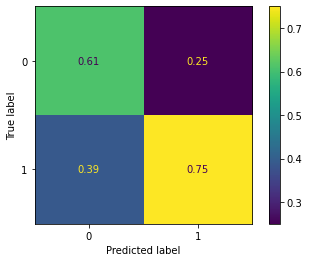

########## Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       1.00      0.46      0.63        13
           1       0.65      1.00      0.79        13

    accuracy                           0.73        26
   macro avg       0.82      0.73      0.71        26
weighted avg       0.83      0.73      0.71        26


Testing Confusion Matrix:



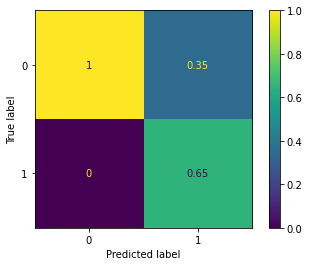

########## Classifier: Random Forest Classifier ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.85      0.85      0.85        13

    accuracy                           0.85        26
   macro avg       0.85      0.85      0.85        26
weighted avg       0.85      0.85      0.85        26


Testing Confusion Matrix:



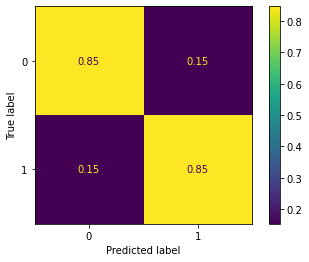

########## Classifier: Ensemble Voting Classifier (Hard) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.79      0.85      0.81        13

    accuracy                           0.81        26
   macro avg       0.81      0.81      0.81        26
weighted avg       0.81      0.81      0.81        26


Testing Confusion Matrix:



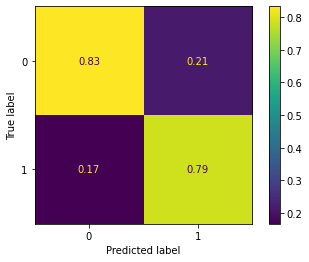

In [428]:
model_KN = KNeighborsClassifier()              # Classifier: Nearest neighbors
model_SV = svm.LinearSVC()                     # Classifier: Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_SV_boost = AdaBoostClassifier(model_SV, algorithm='SAMME') # Classifier: Boosted Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_RF = RandomForestClassifier()            # Classifier: Random Forest Classifier
model_VC = VotingClassifier(estimators=[('KN', model_KN), ('LSVC', model_SV), ('RF', model_RF), ('LSVC_B', model_SV_boost)], voting='hard')
models = [[model_KN, 'Classifier: K-Nearest neighbors'], [model_SV_boost, 'Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC)'],
        [model_RF, 'Classifier: Random Forest Classifier'], [model_VC, 'Classifier: Ensemble Voting Classifier (Hard)']]
test_models2(models)

### The results are slightly worse which would indicate the the model might be recieving too much data. Because of this, we will try and average the band waves of each electrode.

In [429]:
#Summing Bands
dataset3 = dataset2.copy()
columns = dataset3.columns
delta_columns = []
theta_columns = []
alpha_columns = []
beta1_columns = []
beta2_columns = []
gamma_columns = []
for col in columns:
    if col[-5:] == 'delta':
        delta_columns.append(col)
    elif col[-5:] == 'theta':
        theta_columns.append(col)
    elif col[-5:] == 'alpha':
        alpha_columns.append(col)
    elif col[-6:] == 'beta I':
        beta1_columns.append(col)
    elif col[-7:] == 'beta II':
        beta2_columns.append(col)
    elif col[-5:] == 'gamma':
        gamma_columns.append(col)
dataset3['delta'] = dataset3[delta_columns].sum(axis=1)
dataset3['theta'] = dataset3[theta_columns].sum(axis=1)
dataset3['alpha'] = dataset3[alpha_columns].sum(axis=1)
dataset3['beta I'] = dataset3[beta1_columns].sum(axis=1)
dataset3['beta II'] = dataset3[beta2_columns].sum(axis=1)
dataset3['gamma'] = dataset3[gamma_columns].sum(axis=1)

column_list = ['delta', 'theta', 'alpha','beta I', 'beta II', 'gamma','class']
dataset3 = dataset3[column_list]
dataset3

,delta,theta,alpha,beta I,beta II,gamma,class
Subject ID,,,,,,,
Subject20,5.668019,3.228638,5.415186,5.121518,0.538475,0.028163,0
Subject6,8.978768,3.278688,2.922382,3.724593,0.998342,0.097227,1
Subject4,9.073667,3.785848,3.741223,3.127815,0.255918,0.015528,0
Subject22,8.817979,2.831855,4.300008,3.679879,0.366384,0.003896,1
Subject6,8.720028,3.515586,4.384493,2.961938,0.394288,0.023666,0
...,...,...,...,...,...,...,...
Subject11,10.001970,3.288711,2.234221,3.199537,1.192006,0.083556,1
Subject13,12.226051,3.897219,1.730026,1.848742,0.295094,0.002869,1
Subject35,9.708108,3.316268,2.566548,3.817347,0.559099,0.032629,0


In [430]:
#Train Test splitting
Data3 = dataset3.copy()
Y3 = Data3['class']
X3 = Data3.drop(columns='class')
trainX3, testX3, trainY3, testY3 = train_test_split(X3, Y3, test_size = 0.35, stratify=Y3, random_state=21)
#Lets see the data break down
print('Training set dimensions')
print(trainX3.shape)
print(trainY3.shape)
#Class distribution
print('Class 0 (Background EEG)')
print(len(trainY3[trainY3==0]))
print('Class 1 (Mental Math EEG)')
print(len(trainY3[trainY3==1]))
# print(trainX)

print('\nTest set dimensions')
print(testX3.shape)
print(testY3.shape)
#Class distribution
print('Class 0 (Background EEG)')
print(len(testY3[testY3==0]))
print('Class 1 (Mental Math EEG)')
print(len(testY3[testY3==1]))

Training set dimensions
(46, 6)
(46,)
Class 0 (Background EEG)
23
Class 1 (Mental Math EEG)
23

Test set dimensions
(26, 6)
(26,)
Class 0 (Background EEG)
13
Class 1 (Mental Math EEG)
13


In [431]:
#new repeatable testing function
def test_models3(models):
    for model, label in models:
        print(f'########## {label} ##########')
        # Fit model (Logistic Reg.) to the Training data
        model.fit(trainX3, trainY3)
            
        # Predict the classes (y) from test features (X)
        predictedY = model.predict(testX3)


        # print quality metrics
        print('\nTesting Classification Report:\n\n', classification_report(testY3, predictedY))

        print('\nTesting Confusion Matrix:\n')
        disp = ConfusionMatrixDisplay.from_predictions(testY3, predictedY, normalize='pred')
        plt.show()

########## Classifier: K-Nearest neighbors ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       0.75      0.69      0.72        13

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26


Testing Confusion Matrix:



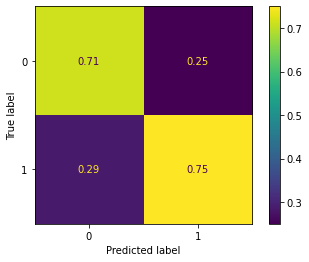

########## Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.67      0.62      0.64        13

    accuracy                           0.65        26
   macro avg       0.65      0.65      0.65        26
weighted avg       0.65      0.65      0.65        26


Testing Confusion Matrix:



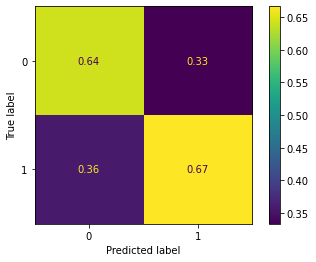

########## Classifier: Random Forest Classifier ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.67      0.62      0.64        13
           1       0.64      0.69      0.67        13

    accuracy                           0.65        26
   macro avg       0.65      0.65      0.65        26
weighted avg       0.65      0.65      0.65        26


Testing Confusion Matrix:



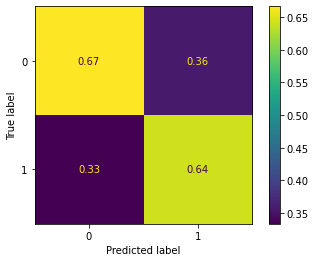

########## Classifier: Ensemble Voting Classifier (Hard) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.56      0.69      0.62        13
           1       0.60      0.46      0.52        13

    accuracy                           0.58        26
   macro avg       0.58      0.58      0.57        26
weighted avg       0.58      0.58      0.57        26


Testing Confusion Matrix:



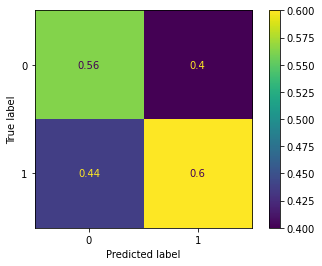

In [432]:
model_KN = KNeighborsClassifier()              # Classifier: Nearest neighbors
model_SV = svm.LinearSVC(max_iter=10000)                     # Classifier: Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_SV_boost = AdaBoostClassifier(model_SV, algorithm='SAMME') # Classifier: Boosted Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_RF = RandomForestClassifier()            # Classifier: Random Forest Classifier
model_VC = VotingClassifier(estimators=[('KN', model_KN), ('LSVC', model_SV), ('RF', model_RF), ('LSVC_B', model_SV_boost)], voting='hard')
models = [[model_KN, 'Classifier: K-Nearest neighbors'], [model_SV_boost, 'Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC)'],
        [model_RF, 'Classifier: Random Forest Classifier'], [model_VC, 'Classifier: Ensemble Voting Classifier (Hard)']]
test_models3(models)

### That was a step in the wrong direction definitey so lets stick to data for each electrode

### One new approach to try is to give the models the entire frequency response of each electrode. This may be too much information but it is worth of some investigation.

In [433]:
#New band collect function
def full_freq(data, Fs, label):
    freq, Sxx= welch(data, Fs, window='hann',nperseg=500, scaling='density')
    Sxx = Sxx
    
    frequency = Sxx/np.sum(Sxx)
    columns = [label + ' ' + str(f) + ' Hz' for f in freq]
    freqs = pd.DataFrame([frequency], columns=columns)
    return freqs

In [434]:
#Collecting data, Full frequency response used as features
set_made=False
data_files = glob.glob("/Users/lperry21/Documents/BME 4050/eeg-during-mental-arithmetic-tasks-1.0.0/*.edf")
for index, file in enumerate(data_files):
    signals, signal_headers, header = highlevel.read_edf(file)
    for index in range(len(signal_headers)):
        if signal_headers[index]['label'] == 'ECG ECG':
            pass
        elif index == 0:
            subject_freq = full_freq(signals[index],Fs=500,label=signal_headers[index]['label'])
            # print(subject_freq)
        else:
            new_freq = full_freq(signals[index],Fs=500,label=signal_headers[index]['label'])
            subject_freq = pd.concat([subject_freq,new_freq], axis=1)
    y = int(file[-5])-1 #file[-5] is the class for background (1) or mental math (2)
    ID = pd.DataFrame([header['patientname']], columns=['Subject ID'])
    y = pd.DataFrame([y], columns=['class'])
    subject_freq = pd.concat([subject_freq,y,ID], axis=1)
    if set_made == False:
        dataset4 = subject_freq
        set_made = True
    else:
        dataset4 = pd.concat([dataset4,subject_freq], axis=0)
dataset4 = dataset4.set_index('Subject ID')
dataset4

,EEG Fp1 0.0 Hz,EEG Fp1 1.0 Hz,EEG Fp1 2.0 Hz,EEG Fp1 3.0 Hz,EEG Fp1 4.0 Hz,EEG Fp1 5.0 Hz,EEG Fp1 6.0 Hz,EEG Fp1 7.0 Hz,EEG Fp1 8.0 Hz,EEG Fp1 9.0 Hz,...,EEG A2-A1 242.0 Hz,EEG A2-A1 243.0 Hz,EEG A2-A1 244.0 Hz,EEG A2-A1 245.0 Hz,EEG A2-A1 246.0 Hz,EEG A2-A1 247.0 Hz,EEG A2-A1 248.0 Hz,EEG A2-A1 249.0 Hz,EEG A2-A1 250.0 Hz,class
Subject ID,,,,,,,,,,,,,,,,,,,,,
Subject20,0.034283,0.163233,0.088697,0.045361,0.047337,0.043804,0.043203,0.045696,0.037703,0.029955,...,1.435027e-10,1.463139e-10,1.456926e-10,1.505880e-10,1.583961e-10,1.567273e-10,1.532757e-10,1.534279e-10,7.598409e-11,0
Subject6,0.088719,0.444498,0.179840,0.066882,0.033394,0.020536,0.018425,0.017503,0.015534,0.014994,...,7.288218e-07,6.769528e-07,6.263724e-07,6.503732e-07,6.330442e-07,6.891333e-07,7.408945e-07,5.874234e-07,2.876616e-07,1
Subject4,0.054585,0.273833,0.139601,0.065565,0.053931,0.042166,0.048268,0.047557,0.035970,0.035150,...,1.206258e-08,1.205118e-08,1.203864e-08,1.206838e-08,1.200313e-08,1.202445e-08,1.203245e-08,1.205067e-08,6.042678e-09,0
Subject22,0.082737,0.393124,0.212970,0.074048,0.037660,0.025146,0.016312,0.011908,0.009093,0.009370,...,4.676401e-09,4.668644e-09,4.663230e-09,4.654828e-09,4.638674e-09,4.628416e-09,4.642954e-09,4.672018e-09,2.341186e-09,1
Subject6,0.052220,0.269678,0.154014,0.083454,0.064736,0.043351,0.040313,0.040153,0.033804,0.030584,...,5.478317e-09,5.477104e-09,5.465391e-09,5.441782e-09,5.440769e-09,5.451514e-09,5.441517e-09,5.402303e-09,2.688738e-09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Subject11,0.044013,0.362310,0.168783,0.055147,0.032617,0.027182,0.026661,0.026960,0.020832,0.018653,...,4.529158e-08,4.522898e-08,4.517857e-08,4.516580e-08,4.505460e-08,4.496564e-08,4.504006e-08,4.518955e-08,2.263960e-08,1
Subject13,0.094133,0.401451,0.235145,0.079195,0.041737,0.029254,0.022660,0.018180,0.013839,0.009104,...,5.016795e-08,5.021414e-08,5.006008e-08,5.004054e-08,5.014307e-08,5.017258e-08,5.016776e-08,5.009177e-08,2.501388e-08,1
Subject35,0.050686,0.278530,0.151116,0.074525,0.054459,0.041800,0.037087,0.036759,0.032589,0.022667,...,3.268537e-08,3.268702e-08,3.269847e-08,3.269085e-08,3.265595e-08,3.262266e-08,3.259239e-08,3.258504e-08,1.629523e-08,0


In [435]:
#Train Test splitting
Data4 = dataset4.copy()
Y4 = Data4['class']
X4 = Data4.drop(columns='class')
trainX4, testX4, trainY4, testY4 = train_test_split(X4, Y4, test_size = 0.35, stratify=Y4, random_state=21)
#Lets see the data break down
print('Training set dimensions')
print(trainX4.shape)
print(trainY4.shape)
#Class distribution
print('Class 0 (Background EEG)')
print(len(trainY4[trainY4==0]))
print('Class 1 (Mental Math EEG)')
print(len(trainY4[trainY4==1]))
# print(trainX)

print('\nTest set dimensions')
print(testX4.shape)
print(testY4.shape)
#Class distribution
print('Class 0 (Background EEG)')
print(len(testY4[testY4==0]))
print('Class 1 (Mental Math EEG)')
print(len(testY4[testY4==1]))

Training set dimensions
(46, 5020)
(46,)
Class 0 (Background EEG)
23
Class 1 (Mental Math EEG)
23

Test set dimensions
(26, 5020)
(26,)
Class 0 (Background EEG)
13
Class 1 (Mental Math EEG)
13


In [436]:
#new repeatable testing function
def test_models4(models):
    for model, label in models:
        print(f'########## {label} ##########')
        # Fit model (Logistic Reg.) to the Training data
        model.fit(trainX4, trainY4)
            
        # Predict the classes (y) from test features (X)
        predictedY = model.predict(testX4)


        # print quality metrics
        print('\nTesting Classification Report:\n\n', classification_report(testY4, predictedY))

        print('\nTesting Confusion Matrix:\n')
        disp = ConfusionMatrixDisplay.from_predictions(testY4, predictedY, normalize='pred')
        plt.show()

########## Classifier: K-Nearest neighbors ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.52      0.92      0.67        13
           1       0.67      0.15      0.25        13

    accuracy                           0.54        26
   macro avg       0.59      0.54      0.46        26
weighted avg       0.59      0.54      0.46        26


Testing Confusion Matrix:



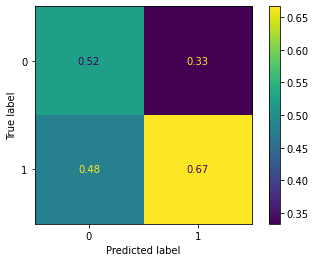

########## Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.60      0.69      0.64        13
           1       0.64      0.54      0.58        13

    accuracy                           0.62        26
   macro avg       0.62      0.62      0.61        26
weighted avg       0.62      0.62      0.61        26


Testing Confusion Matrix:



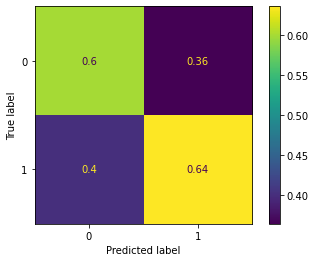

########## Classifier: Random Forest Classifier ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.83      0.77      0.80        13

    accuracy                           0.81        26
   macro avg       0.81      0.81      0.81        26
weighted avg       0.81      0.81      0.81        26


Testing Confusion Matrix:



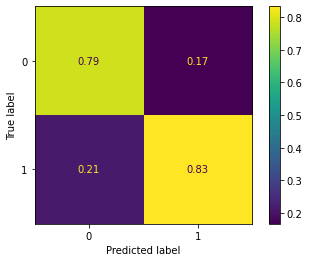

########## Classifier: Ensemble Voting Classifier (Hard) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.65      0.85      0.73        13
           1       0.78      0.54      0.64        13

    accuracy                           0.69        26
   macro avg       0.71      0.69      0.68        26
weighted avg       0.71      0.69      0.68        26


Testing Confusion Matrix:



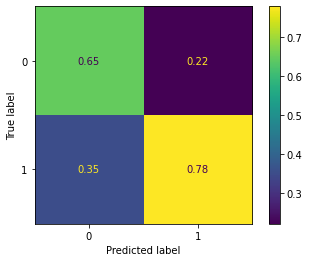

In [439]:
model_KN = KNeighborsClassifier()              # Classifier: Nearest neighbors
model_SV = svm.LinearSVC()                     # Classifier: Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_SV_boost = AdaBoostClassifier(model_SV, algorithm='SAMME') # Classifier: Boosted Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_RF = RandomForestClassifier()            # Classifier: Random Forest Classifier
model_VC = VotingClassifier(estimators=[('KN', model_KN), ('LSVC', model_SV), ('RF', model_RF), ('LSVC_B', model_SV_boost)], voting='hard')
models = [[model_KN, 'Classifier: K-Nearest neighbors'], [model_SV_boost, 'Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC)'],
        [model_RF, 'Classifier: Random Forest Classifier'], [model_VC, 'Classifier: Ensemble Voting Classifier (Hard)']]
test_models4(models)

### After running various different features. It seems that the models performed best with the standard 4 bands: Delta, Theta, Alpha, and Beta. It is also worth knowing that the band values for each electrode was much more effective than summing the band powers of each electrode. This would indicate that the location of the signal plays an important role in the classification which is consistant with the current research. 

## The current best accuracy is 85% with a Voting Classifier take votes from 3 different classifiers: K-nearest neighbors, Boosted Linear SVC, and Random Forest. The features used were the 4 primary bands of each electrode to create a total of 80 features. 
### Now that we know what data preparation to use we can try to further tune the models. Right now the only tuning done is the boosting done on the LSVC. The K-nearest neighbors can be boosted and prelimary testing showed that the default weights='uniform' and n_neighbors=5 was the best combination of hyperparameters. That only leaves the Random Forest Model to try and tune up. One thing that could help is allowing the Random Forest Models to use all the data since the data set is so small. To do that we just set bootstrap to false. Let try that.

########## Classifier: K-Nearest neighbors ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.62      1.00      0.76        13
           1       1.00      0.38      0.56        13

    accuracy                           0.69        26
   macro avg       0.81      0.69      0.66        26
weighted avg       0.81      0.69      0.66        26


Testing Confusion Matrix:



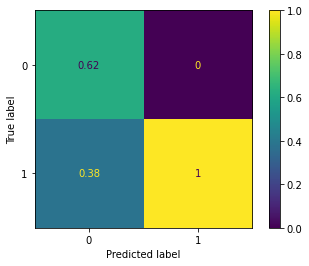

########## Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       0.79      0.85      0.81        13

    accuracy                           0.81        26
   macro avg       0.81      0.81      0.81        26
weighted avg       0.81      0.81      0.81        26


Testing Confusion Matrix:



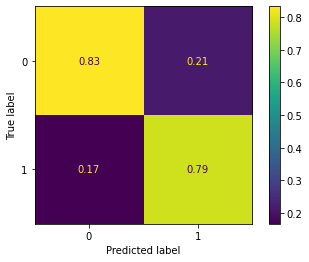

########## Classifier: Random Forest Classifier (No Bootstrap) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.77      0.77      0.77        13

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.77      0.77      0.77        26


Testing Confusion Matrix:



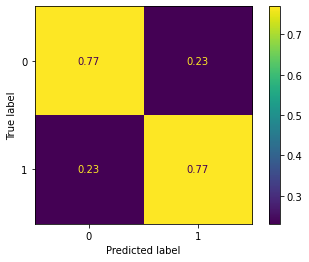

########## Classifier: Ensemble Voting Classifier (Hard) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.92      0.85      0.88        13

    accuracy                           0.88        26
   macro avg       0.89      0.88      0.88        26
weighted avg       0.89      0.88      0.88        26


Testing Confusion Matrix:



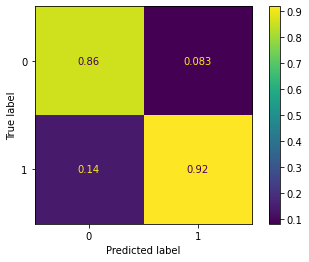

In [423]:
model_KN = KNeighborsClassifier()              # Classifier: Nearest neighbors
model_SV = svm.LinearSVC()                     # Classifier: Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_SV_boost = AdaBoostClassifier(model_SV, algorithm='SAMME') # Classifier: Boosted Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_RF = RandomForestClassifier(bootstrap=False)            # Classifier: Random Forest Classifier (No Bootstrap)
model_VC = VotingClassifier(estimators=[('KN', model_KN), ('LSVC', model_SV), ('RF', model_RF), ('LSVC_B', model_SV_boost)], voting='hard')
models = [[model_KN, 'Classifier: K-Nearest neighbors'], [model_SV_boost, 'Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC)'],
        [model_RF, 'Classifier: Random Forest Classifier (No Bootstrap)'], [model_VC, 'Classifier: Ensemble Voting Classifier (Hard)']]
test_models(models)

### The voting classifier had an increase in accuracy but the actual random forest model decreased in accuracy. The change to the model seemed to have not change so it is safe to assume the model is not actually performing better, but rather the number increased slight just by random chance.

### This amount of change that is seemingly random would indicate that the model needs more data to be trained with. One solution to this problem is to break up the 60 s signals into 10 6 s signals which would increase our sample size by a factor of 10. This would normally be ill adviced as it would cause concern for overfitting but in our model set up with the Voting Classifier should minimize that risk. All we would need to do is to repeat the same process as before except extract 10 data points from each subject instead of 1. 

In [444]:
def get_split_band_power(data, Fs, label):
    split_data = np.array(data).reshape(-1,10)
    columns = [label for i in range(10)]
    split_data = pd.DataFrame(split_data, columns=columns)
    for i in range(10):
        if i == 0:
            subject_data = band_power(signals[i],Fs=500,label=split_data.columns[i])
        else: 
            new_data = band_power(signals[i],Fs=500,label=split_data.columns[i])
            subject_data = pd.concat([subject_data,new_data],axis=0)
    return subject_data

In [445]:
#Collecting data, Features used in this set are the 4 freq bands for each electrode
set_made=False
data_files = glob.glob("/Users/lperry21/Documents/BME 4050/eeg-during-mental-arithmetic-tasks-1.0.0/*.edf")
for index, file in enumerate(data_files):
    signals, signal_headers, header = highlevel.read_edf(file)
    for index in range(len(signal_headers)):
        if signal_headers[index]['label'] == 'ECG ECG':
            pass
        elif index == 0:
            subject1_data = get_split_band_power(signals[index],Fs=500,label=signal_headers[index]['label'])
        else:
            new_signal = get_split_band_power(signals[index],Fs=500,label=signal_headers[index]['label'])
            subject1_data = pd.concat([subject1_data,new_signal], axis=1)
    y = int(file[-5])-1 #file[-5] is the class for background (1) or mental math (2)
    ID = pd.DataFrame([header['patientname']], columns=['Subject ID'])
    y = pd.DataFrame([y], columns=['class'])
    subject1_data = pd.concat([subject1_data,y,ID], axis=1)
    if set_made == False:
        dataset = subject1_data
        set_made = True
    else:
        dataset = pd.concat([dataset,subject1_data], axis=0)
dataset = dataset.set_index('Subject ID')
dataset

,EEG Fp1 delta,EEG Fp1 theta,EEG Fp1 alpha,EEG Fp1 beta,EEG Fp2 delta,EEG Fp2 theta,EEG Fp2 alpha,EEG Fp2 beta,EEG F3 delta,EEG F3 theta,...,EEG Cz beta,EEG Pz delta,EEG Pz theta,EEG Pz alpha,EEG Pz beta,EEG A2-A1 delta,EEG A2-A1 theta,EEG A2-A1 alpha,EEG A2-A1 beta,class
Subject ID,,,,,,,,,,,,,,,,,,,,,
Subject20,0.443907,0.136498,0.212809,0.206786,0.443907,0.136498,0.212809,0.206786,0.443907,0.136498,...,0.206786,0.443907,0.136498,0.212809,0.206786,0.443907,0.136498,0.212809,0.206786,0
Subject20,0.556585,0.098501,0.163061,0.181852,0.556585,0.098501,0.163061,0.181852,0.556585,0.098501,...,0.181852,0.556585,0.098501,0.163061,0.181852,0.556585,0.098501,0.163061,0.181852,0
Subject20,0.308834,0.123659,0.291769,0.275739,0.308834,0.123659,0.291769,0.275739,0.308834,0.123659,...,0.275739,0.308834,0.123659,0.291769,0.275739,0.308834,0.123659,0.291769,0.275739,0
Subject20,0.292205,0.111381,0.305671,0.290743,0.292205,0.111381,0.305671,0.290743,0.292205,0.111381,...,0.290743,0.292205,0.111381,0.305671,0.290743,0.292205,0.111381,0.305671,0.290743,0
Subject20,0.157822,0.146785,0.343948,0.351445,0.157822,0.146785,0.343948,0.351445,0.157822,0.146785,...,0.351445,0.157822,0.146785,0.343948,0.351445,0.157822,0.146785,0.343948,0.351445,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Subject11,0.695948,0.116353,0.091097,0.096601,0.695948,0.116353,0.091097,0.096601,0.695948,0.116353,...,0.096601,0.695948,0.116353,0.091097,0.096601,0.695948,0.116353,0.091097,0.096601,0
Subject11,0.679099,0.112634,0.094630,0.113638,0.679099,0.112634,0.094630,0.113638,0.679099,0.112634,...,0.113638,0.679099,0.112634,0.094630,0.113638,0.679099,0.112634,0.094630,0.113638,0
Subject11,0.679890,0.102392,0.094593,0.123125,0.679890,0.102392,0.094593,0.123125,0.679890,0.102392,...,0.123125,0.679890,0.102392,0.094593,0.123125,0.679890,0.102392,0.094593,0.123125,0


In [446]:
#Train test splitting
Data = dataset.copy()
Y = Data['class']
X = Data.drop(columns='class')
# print('X')
# print(X)
# print('Y')
# print(Y)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.35, stratify=Y, random_state=21)
#Lets see the data break down
print('Training set dimensions')
print(trainX.shape)
print(trainY.shape)
#Class distribution
print('Class 0 (Background EEG)')
print(len(trainY[trainY==0]))
print('Class 1 (Mental Math EEG)')
print(len(trainY[trainY==1]))
# print(trainX)

print('\nTest set dimensions')
print(testX.shape)
print(testY.shape)
#Class distribution
print('Class 0 (Background EEG)')
print(len(testY[testY==0]))
print('Class 1 (Mental Math EEG)')
print(len(testY[testY==1]))

Training set dimensions
(468, 80)
(468,)
Class 0 (Background EEG)
234
Class 1 (Mental Math EEG)
234

Test set dimensions
(252, 80)
(252,)
Class 0 (Background EEG)
126
Class 1 (Mental Math EEG)
126


########## Classifier: K-Nearest neighbors ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.61      0.60      0.60       126
           1       0.60      0.62      0.61       126

    accuracy                           0.61       252
   macro avg       0.61      0.61      0.61       252
weighted avg       0.61      0.61      0.61       252


Testing Confusion Matrix:



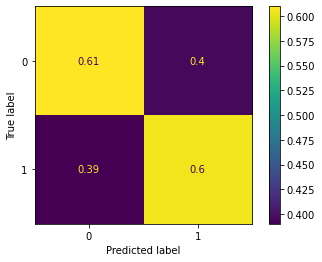

########## Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.61      0.63      0.62       126
           1       0.62      0.59      0.60       126

    accuracy                           0.61       252
   macro avg       0.61      0.61      0.61       252
weighted avg       0.61      0.61      0.61       252


Testing Confusion Matrix:



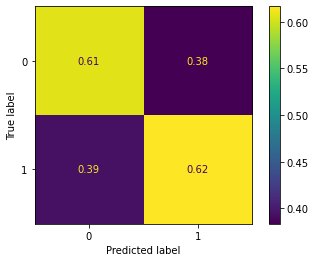

########## Classifier: Random Forest Classifier ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.61      0.67      0.64       126
           1       0.63      0.56      0.60       126

    accuracy                           0.62       252
   macro avg       0.62      0.62      0.62       252
weighted avg       0.62      0.62      0.62       252


Testing Confusion Matrix:



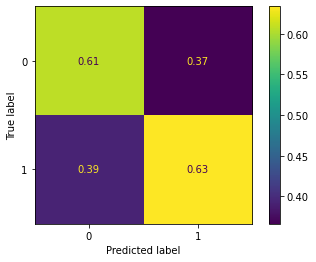

########## Classifier: Ensemble Voting Classifier (Hard) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.62      0.76      0.68       126
           1       0.69      0.53      0.60       126

    accuracy                           0.65       252
   macro avg       0.66      0.65      0.64       252
weighted avg       0.66      0.65      0.64       252


Testing Confusion Matrix:



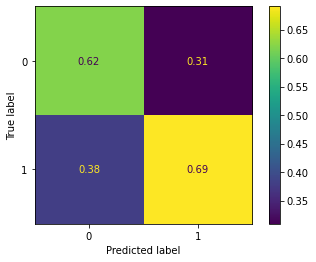

In [450]:
model_KN = KNeighborsClassifier()              # Classifier: Nearest neighbors
model_SV = svm.LinearSVC()                     # Classifier: Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_SV_boost = AdaBoostClassifier(model_SV, algorithm='SAMME') # Classifier: Boosted Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_RF = RandomForestClassifier()            # Classifier: Random Forest Classifier
model_VC = VotingClassifier(estimators=[('KN', model_KN), ('LSVC', model_SV), ('RF', model_RF), ('LSVC_B', model_SV_boost)], voting='hard')
models = [[model_KN, 'Classifier: K-Nearest neighbors'], [model_SV_boost, 'Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC)'],
        [model_RF, 'Classifier: Random Forest Classifier'], [model_VC, 'Classifier: Ensemble Voting Classifier (Hard)']]
test_models(models)

In [451]:
def get_split_new_band_power(data, Fs, label):
    split_data = np.array(data).reshape(-1,10)
    columns = [label for i in range(10)]
    split_data = pd.DataFrame(split_data, columns=columns)
    for i in range(10):
        if i == 0:
            subject_data = new_band_power(signals[i],Fs=500,label=split_data.columns[i])
        else: 
            new_data = new_band_power(signals[i],Fs=500,label=split_data.columns[i])
            subject_data = pd.concat([subject_data,new_data],axis=0)
    return subject_data

In [454]:
#Collecting data (same process with new band function), Features used in this set are the 6 freq bands for each electrode
set_made=False
data_files = glob.glob("/Users/lperry21/Documents/BME 4050/eeg-during-mental-arithmetic-tasks-1.0.0/*.edf")
for index, file in enumerate(data_files):
    signals, signal_headers, header = highlevel.read_edf(file)
    for index in range(len(signal_headers)):
        if signal_headers[index]['label'] == 'ECG ECG':
            pass
        elif index == 0:
            subject1_data = get_split_new_band_power(signals[index],Fs=500,label=signal_headers[index]['label'])
        else:
            new_signal = get_split_new_band_power(signals[index],Fs=500,label=signal_headers[index]['label'])
            subject1_data = pd.concat([subject1_data,new_signal], axis=1)
    y = int(file[-5])-1 #file[-5] is the class for background (1) or mental math (2)
    ID = pd.DataFrame([header['patientname']], columns=['Subject ID'])
    y = pd.DataFrame([y], columns=['class'])
    subject1_data = pd.concat([subject1_data,y,ID], axis=1)
    if set_made == False:
        dataset2 = subject1_data
        set_made = True
    else:
        dataset2 = pd.concat([dataset2,subject1_data], axis=0)
dataset2 = dataset2.set_index('Subject ID')
dataset2

,EEG Fp1 delta,EEG Fp1 theta,EEG Fp1 alpha,EEG Fp1 beta I,EEG Fp1 beta II,EEG Fp1 gamma,EEG Fp2 delta,EEG Fp2 theta,EEG Fp2 alpha,EEG Fp2 beta I,...,EEG Pz beta I,EEG Pz beta II,EEG Pz gamma,EEG A2-A1 delta,EEG A2-A1 theta,EEG A2-A1 alpha,EEG A2-A1 beta I,EEG A2-A1 beta II,EEG A2-A1 gamma,class
Subject ID,,,,,,,,,,,,,,,,,,,,,
Subject20,0.286937,0.188397,0.214041,0.274132,0.034478,0.002015,0.286937,0.188397,0.214041,0.274132,...,0.274132,0.034478,0.002015,0.286937,0.188397,0.214041,0.274132,0.034478,0.002015,0
Subject20,0.337801,0.164203,0.187722,0.254019,0.053473,0.002783,0.337801,0.164203,0.187722,0.254019,...,0.254019,0.053473,0.002783,0.337801,0.164203,0.187722,0.254019,0.053473,0.002783,0
Subject20,0.209621,0.164349,0.268701,0.324520,0.031561,0.001248,0.209621,0.164349,0.268701,0.324520,...,0.324520,0.031561,0.001248,0.209621,0.164349,0.268701,0.324520,0.031561,0.001248,0
Subject20,0.198894,0.138818,0.266025,0.355161,0.040095,0.001006,0.198894,0.138818,0.266025,0.355161,...,0.355161,0.040095,0.001006,0.198894,0.138818,0.266025,0.355161,0.040095,0.001006,0
Subject20,0.102956,0.193370,0.285637,0.350302,0.064226,0.003509,0.102956,0.193370,0.285637,0.350302,...,0.350302,0.064226,0.003509,0.102956,0.193370,0.285637,0.350302,0.064226,0.003509,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Subject11,0.576044,0.170445,0.094960,0.128131,0.030029,0.000391,0.576044,0.170445,0.094960,0.128131,...,0.128131,0.030029,0.000391,0.576044,0.170445,0.094960,0.128131,0.030029,0.000391,0
Subject11,0.542028,0.175655,0.099538,0.140670,0.041479,0.000630,0.542028,0.175655,0.099538,0.140670,...,0.140670,0.041479,0.000630,0.542028,0.175655,0.099538,0.140670,0.041479,0.000630,0
Subject11,0.572483,0.138521,0.095476,0.148846,0.043843,0.000832,0.572483,0.138521,0.095476,0.148846,...,0.148846,0.043843,0.000832,0.572483,0.138521,0.095476,0.148846,0.043843,0.000832,0


In [455]:
#Train Test Splitting
Data2 = dataset2.copy()
Y2 = Data2['class']
X2 = Data2.drop(columns='class')
# print('X')
# print(X)
# print('Y')
# print(Y)
trainX2, testX2, trainY2, testY2 = train_test_split(X2, Y2, test_size = 0.35, stratify=Y2, random_state=21)
#Lets see the data break down
print('Training set dimensions')
print(trainX2.shape)
print(trainY2.shape)
#Class distribution
print('Class 0 (Background EEG)')
print(len(trainY2[trainY2==0]))
print('Class 1 (Mental Math EEG)')
print(len(trainY2[trainY2==1]))
# print(trainX)

print('\nTest set dimensions')
print(testX2.shape)
print(testY2.shape)
#Class distribution
print('Class 0 (Background EEG)')
print(len(testY2[testY2==0]))
print('Class 1 (Mental Math EEG)')
print(len(testY2[testY2==1]))

Training set dimensions
(468, 120)
(468,)
Class 0 (Background EEG)
234
Class 1 (Mental Math EEG)
234

Test set dimensions
(252, 120)
(252,)
Class 0 (Background EEG)
126
Class 1 (Mental Math EEG)
126


########## Classifier: K-Nearest neighbors ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.68      0.69      0.69       126
           1       0.69      0.67      0.68       126

    accuracy                           0.68       252
   macro avg       0.68      0.68      0.68       252
weighted avg       0.68      0.68      0.68       252


Testing Confusion Matrix:



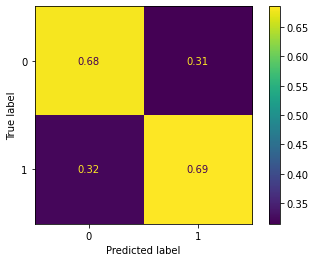

########## Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.61      0.56      0.58       126
           1       0.59      0.63      0.61       126

    accuracy                           0.60       252
   macro avg       0.60      0.60      0.60       252
weighted avg       0.60      0.60      0.60       252


Testing Confusion Matrix:



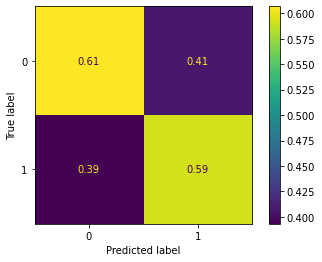

########## Classifier: Random Forest Classifier ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.68      0.71      0.69       126
           1       0.69      0.67      0.68       126

    accuracy                           0.69       252
   macro avg       0.69      0.69      0.69       252
weighted avg       0.69      0.69      0.69       252


Testing Confusion Matrix:



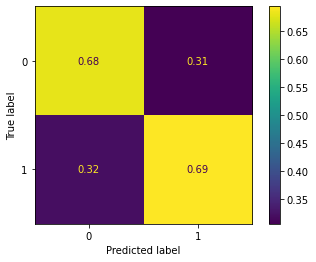

########## Classifier: Ensemble Voting Classifier (Hard) ##########

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.62      0.75      0.68       126
           1       0.69      0.55      0.61       126

    accuracy                           0.65       252
   macro avg       0.66      0.65      0.65       252
weighted avg       0.66      0.65      0.65       252


Testing Confusion Matrix:



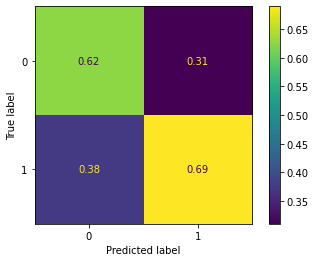

In [458]:
model_KN = KNeighborsClassifier()              # Classifier: Nearest neighbors
model_SV = svm.LinearSVC()                     # Classifier: Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_SV_boost = AdaBoostClassifier(model_SV, algorithm='SAMME') # Classifier: Boosted Support Vector Machine (SVM)- linear support vector classifier (SVC)
model_RF = RandomForestClassifier()            # Classifier: Random Forest Classifier
model_VC = VotingClassifier(estimators=[('KN', model_KN), ('LSVC', model_SV), ('RF', model_RF), ('LSVC_B', model_SV_boost)], voting='hard')
models = [[model_KN, 'Classifier: K-Nearest neighbors'], [model_SV_boost, 'Classifier: BOOSTED Support Vector Machine (SVM)- linear support vector classifier (SVC)'],
        [model_RF, 'Classifier: Random Forest Classifier'], [model_VC, 'Classifier: Ensemble Voting Classifier (Hard)']]
test_models2(models)